# Local chiral potentials

This notebook is dedicated to local chiral potentials. It creates the figures in the manuscript associated with this potential.

We use here the local chiral potentials [GT+](https://arxiv.org/abs/1406.0454) up to N2LO, which are commonly used in quantum Monte Carlo (QMC) calculations of finite nuclei and infinite matter. 

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")
output_dir = "./output"

import numpy as np
import matplotlib.pyplot as plt
from Potential import Potential, chiral, chiral_affine
from Channel import Channel
from ScatteringExp import ScatteringExp
from RseSolver import RseSolver
from Grid import Grid
from plots.rc_params import *
from string import ascii_lowercase as alphabet

## Affine version

We have developed an affine decomposed version of the original `C++` source code provided by the developers. It matches the original, non-affine decomposed version of the code very well. This section illustrates the workflow.

First, we obtain the parameter-independent portion of the chiral potentials:

In [2]:
potentialArgs = {"label": "chiral", "potId": 233}
channel = Channel(S=1, L=2, LL=2, J=1, channel=0)  # pick here the channel
potential = Potential(channel, **potentialArgs)
r = 1 # fm
aff_decomp = chiral_affine(r, channel, **potentialArgs)
aff_decomp

array([  -5.53041341,   15.31411662,   15.31411662, -102.3864922 ,
        307.15947659, -102.3864922 ,  307.15947659, -140.04679124,
        220.85788572, -662.57365715,    0.        ,    0.        ])

Note that several terms are equivalent or multiple of each other. This is because of the partial wave decomposition. 

Next, we read in the values of the low-energy couplings (LECs) from the provided data (i.e., `yaml`) files:

In [3]:
import yaml
with open("data/localGT+_lecs_order_2_R0_0.9_lam_1000.yaml", 'r') as stream:
    lecs = yaml.safe_load(stream)
lecs

{'potId': 233,
 'order': 2,
 'R0': 0.9,
 'lambda': 1000,
 'CS': 7.74784,
 'CNN': 0.04164,
 'CPP': 0.06329,
 'CT': 0.45247,
 'C1': -0.21715,
 'C2': 0.03457,
 'C3': -0.11535,
 'C4': 0.11818,
 'C5': -2.41603,
 'C6': 0.15463,
 'C7': -0.26709}

Next, we reconstruct a local chiral potential using the affine decomposition. This involves a dot product. We also evaluate the potential using the function provided by the developers. The two functions should result in the same results:

In [4]:
lec_vec = np.array([1.] + [lecs[elem] for elem in ("CS", "CT", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "CNN", "CPP")])
potval_via_aff_decomp = aff_decomp @ lec_vec
potval = chiral(r, channel,  **lecs)
diff = np.abs(potval_via_aff_decomp - potval)
assert diff < 1e-13, f"difference (aff. vs. nonaffine evaluation): {diff:e} MeV"

For completeness, let's plot the potential in the requested partial-wave channel:

Text(0.5, 1.0, '$^3\\mathrm{D}_1^{(np)}$')

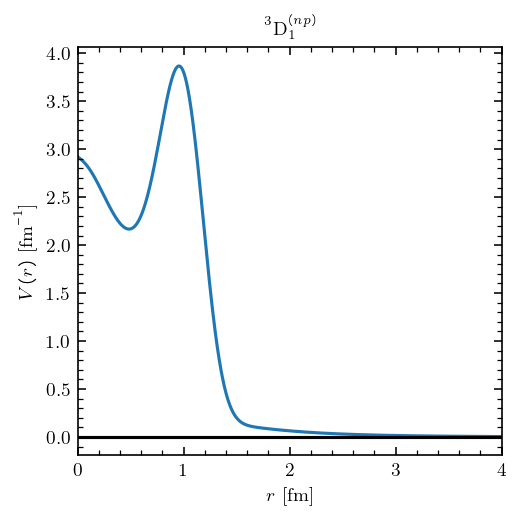

In [5]:
from constants import hbarc, cm 
fig, ax = plt.subplots(1,1, sharex=True, figsize=(8.6*cm,8.6*cm), constrained_layout=True)
rarr = np.linspace(0., 4., 1000)
yarr = np.array([chiral(r, channel, **lecs) for r in rarr])
ax.plot(rarr, yarr / hbarc)
ax.axhline(0, c="k")
ax.set_xlabel("$r$ [fm]")
ax.set_xlim(0,4)
ax.set_ylabel("$V(r)$ [fm$^{-1}$]")
ax.set_title(channel.spectNotationTeX)

The figure can be compared with Figure 14 in [Hoppe et al.](https://arxiv.org/pdf/1707.06438) (2017).

## Benchmarking the matrix Numerov method (Figure 2)

In [6]:
potentialArgs = {"label": "chiral", "potId": 213}
trainingLecList, validationLecList = Potential.getSampleLecs(potentialArgs["label"])
rmin, rmatch = 1e-12, 12
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 
solver_args = dict(asympParam="K", matching=True)

def f(E_MeV, channel, inhomogeneous=True):
    potential = Potential(channel, **potentialArgs)
    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
    solver = RseSolver(scattExp, grid, inhomogeneous=inhomogeneous)
    scattSols_numerov = solver.solve(lecList=validationLecList, method="Numerov_affine", **solver_args)
    scattSols_rk45 = solver.solve(lecList=validationLecList, method="RK45", **solver_args)
    return [scattSols_numerov[0], scattSols_rk45[0]]

Notice that we use above the affine version of the Numerov implementation. We could also switch to `method="Numerov"` to use the non-affine version.

working on 1S0np
working on 3P0np
working on 1P1np
working on 3P1np
working on 1D2np
working on 1F3np


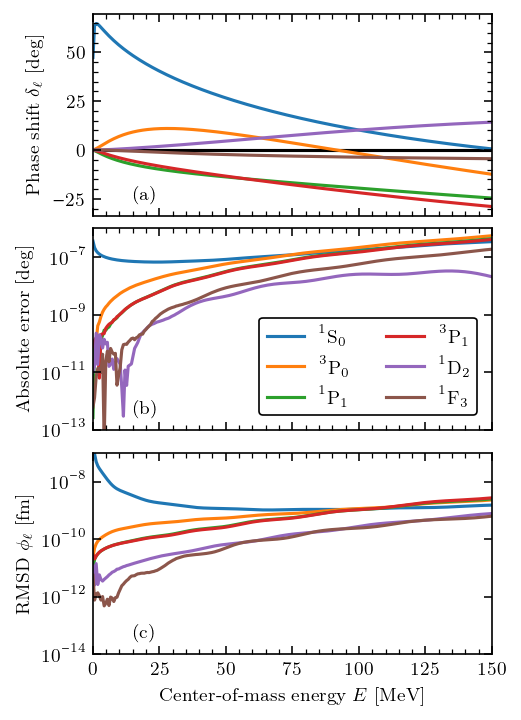

In [7]:
from constants import cm
import pandas as pd
inhomogeneous = True
channel_lbls = ("1S0np", "3P0np", "1P1np", "3P1np", "1D2np", "1F3np")
channels = [Channel(as_str=elem) for elem in channel_lbls]
energies_MeV = np.linspace(1e-1, 150, 250)
fig, axs = plt.subplots(3,1, sharex=True, figsize=(8.6*cm,12*cm), constrained_layout=True)

for channel in channels:
    print("working on", channel.spectNotation)
    ret_raw = []
    for E_MeV in energies_MeV:
        ret_raw.append(f(E_MeV=E_MeV, channel=channel, inhomogeneous=inhomogeneous))

    ret = np.array([[elem[0].Lmatrix.phaseShift, elem[1].Lmatrix.phaseShift] for elem in ret_raw])
    df = pd.DataFrame(data={"Energies (MeV)": energies_MeV,
                            "Numerov (deg)": ret[:,0], 
                            "RK45 (deg)": ret[:,1]})
    df.to_csv(f"{output_dir}/benchmkark_numerov_chiral_phaseshifts_{channel.spectNotation}.csv",
              index=False, float_format="%.5f")
    axs[0].plot(energies_MeV, np.real(ret[:,0]))
    axs[1].plot(energies_MeV, np.abs(ret[:,0]-ret[:,1]), label=channel.spectNotationTeX.replace("^{(np)}",""))
    rms_error = [np.linalg.norm((elem[0].u - elem[1].u)) / np.sqrt(len(elem[0].u)) for elem in ret_raw ]
    axs[2].plot(energies_MeV, rms_error, label=channel.spectNotationTeX.replace("^{(np)}",""))

axs[0].axhline(0, color = "k", zorder=0)
axs[0].set_ylabel(r"Phase shift $\delta_\ell$ [deg]")

axs[1].set_yscale('log')
axs[1].set_ylim(bottom=1e-13, top=1e-6)
axs[1].set_xlim(left=0, right=150)
axs[1].set_ylabel("Absolute error [deg]") #  $\Delta \delta_\ell$ [deg]")
axs[1].legend(ncol=2) # title="$\ell = $"

axs[2].set_yscale('log')
axs[2].set_xlim(left=0, right=150)
axs[2].set_ylim(bottom=1e-14, top=1e-7)
axs[2].set_xlabel("Center-of-mass energy $E$ [MeV]")
axs[2].set_ylabel(r"RMSD $\phi_\ell$ [fm]")

for iax, ax in enumerate(axs):
    ax.text(0.10, 0.08, f"({alphabet[iax]})", transform=ax.transAxes)

fig.savefig(f"{output_dir}/numerov_benchmark.pdf")

Next, we benchmark the obtained phase shifts again a corresponding momentum-space calculation that solves the Lippmann-Schwinger Equation We also compare them to the extracted results from the PWA93.

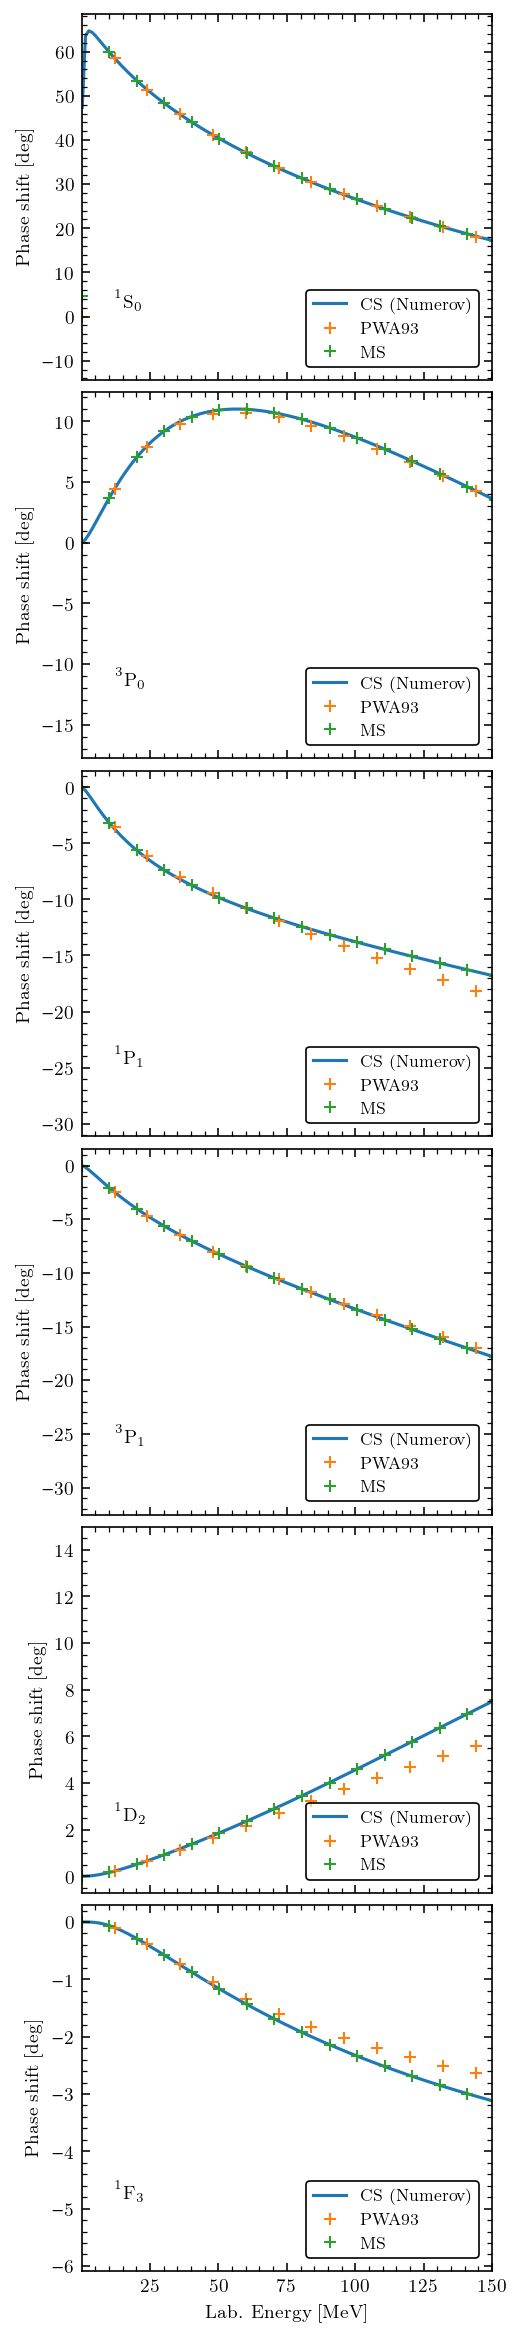

In [8]:
fig, axs = plt.subplots(len(channels), 1, 
                        figsize=(8.6*cm,6.6*cm*len(channels)), 
                        constrained_layout=True,
                        sharex=True, sharey=False)
for ichannel, channel in enumerate(channels):
    ax = axs[ichannel]
    data_calc = pd.read_csv(f"{output_dir}/benchmkark_numerov_chiral_phaseshifts_{channel.spectNotation}.csv")
    data_calc["Tlab (MeV)"] = data_calc["Energies (MeV)"]*2
    data_ref = pd.read_csv(
        f"./data/phaseshifts/nn-online/PWA93-{channel.spectNotation[:-2]}-np.txt", 
        skiprows=0, names=("Tlab", "phaseshift"), 
        skipinitialspace=True, index_col=False, comment="#", sep=" "
        )

    data_calc_ms = pd.read_csv(
        f"./data/phaseshifts/N2LO_fulllocal_R0_1.0_lam_50.0_Np_54/phaseShifts_{channel.spectNotation}.txt", 
        skiprows=0, skipinitialspace=True, index_col=False, 
        comment="#", sep=" ", names=("Tlab (MeV)", "phaseshift")
        )

    # ax.plot(data_calc["Tlab (MeV)"], data_calc["RK45 (deg)"], label="CS (RK45)")
    ax.plot(data_calc["Tlab (MeV)"], data_calc["Numerov (deg)"], label="CS (Numerov)")
    ax.plot(data_ref["Tlab"], data_ref["phaseshift"], 
            ls="", marker="+", ms=6, markevery = 120, label="PWA93")
    ax.plot(data_calc_ms["Tlab (MeV)"], data_calc_ms["phaseshift"], 
            ls="", marker="+", ms=6, markevery=5, label="MS")

    ax.text(0.08, 0.2, f"{channel.spectNotationTeXShort}", transform=ax.transAxes)
    if ichannel == len(channels) - 1:
        ax.set_xlabel("Lab. Energy [MeV]")
    ax.set_ylabel("Phase shift [deg]")
    ax.set_xlim(energies_MeV[0], energies_MeV[-1])
    ax.legend(loc="lower right", ncol=1, fontsize=8)

Note that the MS and CS calculations agree well. They are not expected to exactly reproduce the PWA93 results, see Figs. 3-6 in the [Gezerlis et al.](https://arxiv.org/pdf/1406.0454) publication.

For completeness, we look at the full wave functions and scattered wave functions at a single energy in those partial wave channels as a function of the radius.

working on 1S0np
working on 3P0np
working on 1P1np
working on 3P1np
working on 1D2np
working on 1F3np


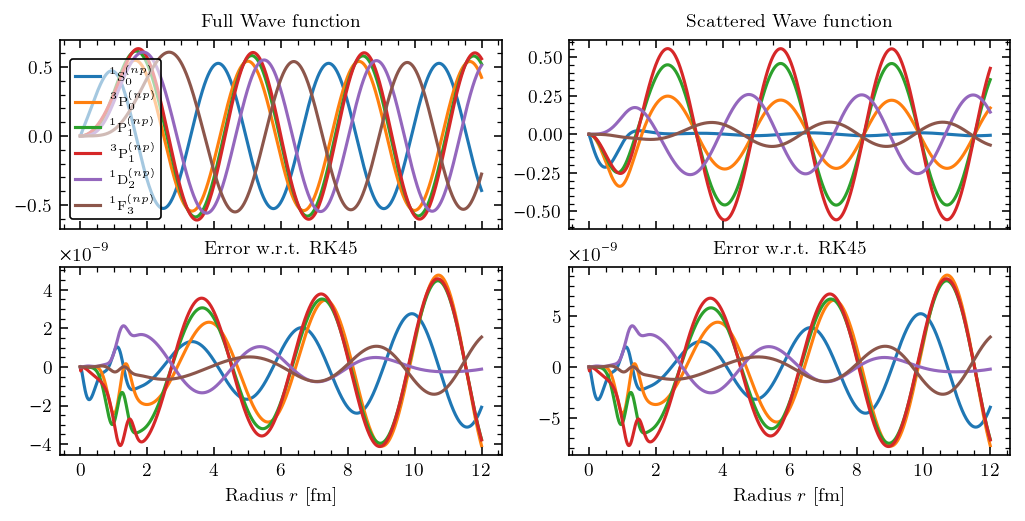

In [9]:
from constants import cm
import pandas as pd
inhomogeneous = True
energy = 50  # MeV
fig, axs = plt.subplots(2,2, sharex=True, figsize=(2*8.6*cm,8.6*cm), constrained_layout=True)

for channel in channels:
    print("working on", channel.spectNotation)
    ret = f(E_MeV=E_MeV, channel=channel, inhomogeneous=inhomogeneous)
    axs[0,0].plot(grid.points, ret[0].u, label=channel.spectNotationTeX)
    axs[0,1].plot(grid.points, ret[0].chi)
    axs[1,0].plot(grid.points, ret[0].u - ret[1].u) # Numerov
    axs[1,1].plot(grid.points, ret[0].chi - ret[1].chi) 

axs[0,0].legend(fontsize=6)
axs[0,0].set_title("Full Wave function")
axs[0,1].set_title("Scattered Wave function")
for ax in axs[1,:]:
    ax.set_title("Error w.r.t. RK45")
    ax.set_xlabel("Radius $r$ [fm]")

We can see that the errors in the wave functions are similar when solving the homogeneous RSE compared to the inhomogeneous RSE.

## Convergence analysis

In [10]:
from constants import hbarc, cm
channel = Channel(as_str="1S0np")
potentialArgs = {"label": "chiral", "potId": 213}
potential = Potential(channel, **potentialArgs)
seed = 124294784
np.random.seed(seed)
percent_variation = 50
var_ranges = {leclbl: percent_variation for leclbl in ("CS", "CT", "C1", "C2", 
                                                       "C3", "C4", "C5", "C6", "C7")}
param_samples = {
    "training": potential.getLecsSample(var_ranges, n=200, seed=seed),
    "validation": potential.getLecsSample(var_ranges, n=10000, seed=seed)
}

In [11]:
from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd
from os.path import isfile

use_prestored = True
E_MeV_arr = (50, 100)
emulator_type = "grom"

for E_MeV in E_MeV_arr:
    df = pd.DataFrame()
    print(f"working on E = {E_MeV} MeV")
    output_file = f"output/df_conv_chiral_{channel.spectNotation}_{emulator_type}_{E_MeV}_MeV.csv.gz"
    if use_prestored and isfile(output_file):
        print(f"\tusing '{output_file}'")
        continue
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, 
                              potential_lbl="chiral",
                              emulator_type=emulator_type,
                              seed=123456, take_all=False)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df.to_csv(output_file, index=False)
    print("")

/Users/drischler/GitHub/greedy_emulator/modules/figures.py:248: SyntaxWarning: invalid escape sequence '\;'
  ax.text(0.95, 0.78, f"$E = {E_MeV_arr[iE_MeV]}" + "\; \mathrm{MeV}$ ",


working on E = 50 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 26  45 104]
best idxs: [139 175 178]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking POD emulator
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking LHS emulator
	running with 3 snapshots (100 samples)
	running with 4 snapshots (100 samples)
	running with 5 snapshots (100 samples)
	running with 6 snapshots (100 samples)
	running with 7 snapshots (100 samples)
	running with 8 snapshots (100 samples)

working on E = 100 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 54 127 142]
best idxs: [  5  21 187]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 

reading 'output/df_conv_chiral_1S0np_grom_50_MeV.csv.gz'
reading 'output/df_conv_chiral_1S0np_grom_100_MeV.csv.gz'


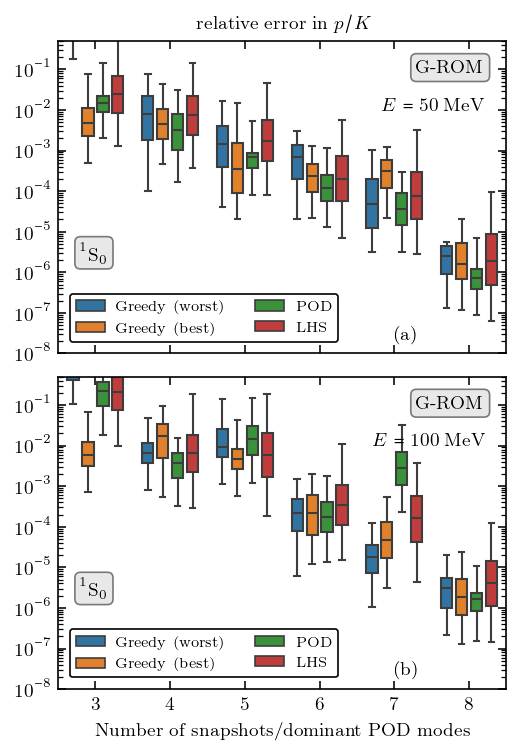

In [12]:
emulator_type = "grom"
convergenceFig(E_MeV_arr, emulator_type, 
               potential_lbl="chiral", channel=channel)

In [13]:
from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd
from os.path import isfile

use_prestored = True
E_MeV_arr = (50, 100)
emulator_type = "lspg"

for E_MeV in E_MeV_arr:
    df = pd.DataFrame()
    print(f"working on E = {E_MeV} MeV")
    output_file = f"output/df_conv_chiral_{channel.spectNotation}_{emulator_type}_{E_MeV}_MeV.csv.gz"
    if use_prestored and isfile(output_file):
        print(f"\tusing '{output_file}'")
        continue
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, 
                              potential_lbl="chiral",
                              emulator_type=emulator_type,
                              seed=123456, take_all=False)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df.to_csv(output_file, index=False)
    print("")

working on E = 50 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 71  93 119]
best idxs: [ 20  99 107]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking POD emulator
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking LHS emulator
	running with 3 snapshots (100 samples)
	running with 4 snapshots (100 samples)
	running with 5 snapshots (100 samples)
	running with 6 snapshots (100 samples)
	running with 7 snapshots (100 samples)
	running with 8 snapshots (100 samples)

working on E = 100 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 71  93 119]
best idxs: [  3  24 115]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 

reading 'output/df_conv_chiral_1S0np_lspg_50_MeV.csv.gz'
reading 'output/df_conv_chiral_1S0np_lspg_100_MeV.csv.gz'


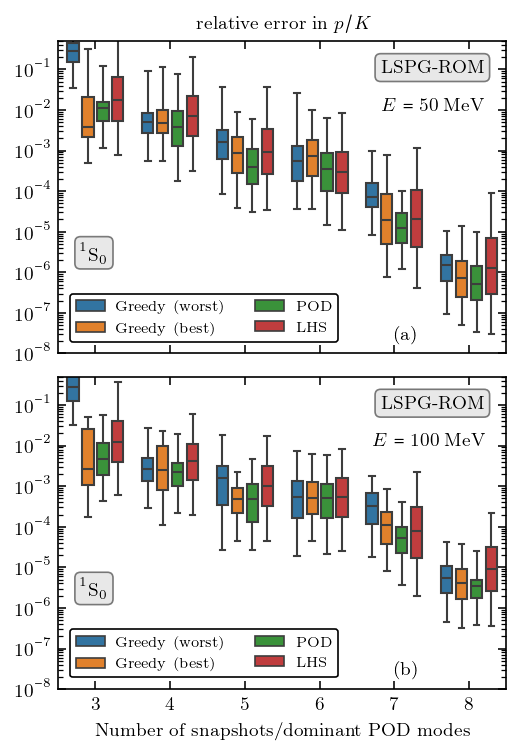

In [14]:
emulator_type = "lspg"
convergenceFig(E_MeV_arr, emulator_type, 
               potential_lbl="chiral", channel=channel)

## Convergence analysis (continued)

In [16]:
from constants import hbarc, cm
channel = Channel(as_str="3P0np")
potentialArgs = {"label": "chiral", "potId": 213}
potential = Potential(channel, **potentialArgs)
seed = 124294784
np.random.seed(seed)
percent_variation = 50
var_ranges = {leclbl: percent_variation for leclbl in ("CS", "CT", "C1", "C2", 
                                                       "C3", "C4", "C5", "C6", "C7")}
param_samples = {
    "training": potential.getLecsSample(var_ranges, n=200, seed=seed),
    "validation": potential.getLecsSample(var_ranges, n=10000, seed=seed)
}

In [17]:
from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd
from os.path import isfile

use_prestored = True
E_MeV_arr = (50, 100)
emulator_type = "grom"

for E_MeV in E_MeV_arr:
    df = pd.DataFrame()
    print(f"working on E = {E_MeV} MeV")
    output_file = f"output/df_conv_chiral_{channel.spectNotation}_{emulator_type}_{E_MeV}_MeV.csv.gz"
    if use_prestored and isfile(output_file):
        print(f"\tusing '{output_file}'")
        continue
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, 
                              potential_lbl="chiral",
                              emulator_type=emulator_type,
                              seed=123456, take_all=False)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df.to_csv(output_file, index=False)
    print("")

working on E = 50 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 26  45 104]
best idxs: [139 175 178]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking POD emulator
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking LHS emulator
	running with 3 snapshots (100 samples)
	running with 4 snapshots (100 samples)
	running with 5 snapshots (100 samples)
	running with 6 snapshots (100 samples)
	running with 7 snapshots (100 samples)
	running with 8 snapshots (100 samples)

working on E = 100 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 54 127 142]
best idxs: [  5  21 187]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 

reading 'output/df_conv_chiral_3P0np_grom_50_MeV.csv.gz'
reading 'output/df_conv_chiral_3P0np_grom_100_MeV.csv.gz'


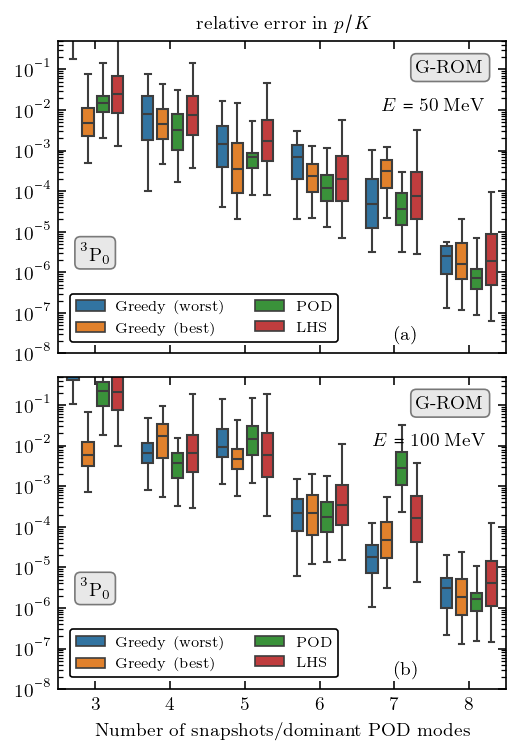

In [18]:
emulator_type = "grom"
convergenceFig(E_MeV_arr, emulator_type, 
               potential_lbl="chiral", channel=channel)

In [19]:
from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd
from os.path import isfile

use_prestored = True
E_MeV_arr = (50, 100)
emulator_type = "lspg"

for E_MeV in E_MeV_arr:
    df = pd.DataFrame()
    print(f"working on E = {E_MeV} MeV")
    output_file = f"output/df_conv_chiral_{channel.spectNotation}_{emulator_type}_{E_MeV}_MeV.csv.gz"
    if use_prestored and isfile(output_file):
        print(f"\tusing '{output_file}'")
        continue
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, 
                              potential_lbl="chiral",
                              emulator_type=emulator_type,
                              seed=123456, take_all=False)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df.to_csv(output_file, index=False)
    print("")

working on E = 50 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 71  93 119]
best idxs: [ 20  99 107]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking POD emulator
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking LHS emulator
	running with 3 snapshots (100 samples)
	running with 4 snapshots (100 samples)
	running with 5 snapshots (100 samples)
	running with 6 snapshots (100 samples)
	running with 7 snapshots (100 samples)
	running with 8 snapshots (100 samples)

working on E = 100 MeV
scanning 100 (out of 1313400) for best/worst initial emulator basis
worst idxs: [ 71  93 119]
best idxs: [  3  24 115]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 

reading 'output/df_conv_chiral_3P0np_lspg_50_MeV.csv.gz'
reading 'output/df_conv_chiral_3P0np_lspg_100_MeV.csv.gz'


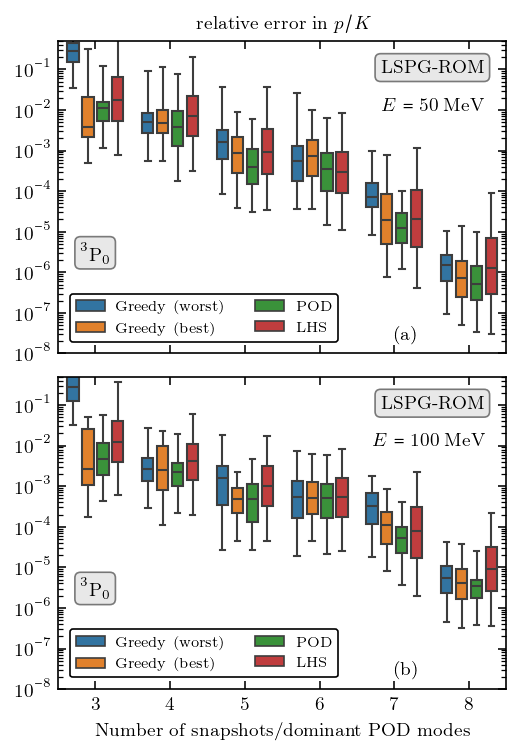

In [20]:
emulator_type = "lspg"
convergenceFig(E_MeV_arr, emulator_type, 
               potential_lbl="chiral", channel=channel)

In [ ]:
from constants import hbarc, cm
channel = Channel(as_str="3P0np")
potentialArgs = {"label": "chiral", "potId": 213}
potential = Potential(channel, **potentialArgs)
seed = 124294784
np.random.seed(seed)
percent_variation = 50
var_ranges = {leclbl: percent_variation for leclbl in ("CS", "CT", "C1", "C2", 
                                                       "C3", "C4", "C5", "C6", "C7")}
param_samples = {
    "training": potential.getLecsSample(var_ranges, n=200, seed=seed),
    "validation": potential.getLecsSample(var_ranges, n=10000, seed=seed)
}

from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd
from os.path import isfile

use_prestored = True
E_MeV_arr = (50, 100)
emulator_type = "lspg"

for E_MeV in E_MeV_arr:
    df = pd.DataFrame()
    print(f"working on E = {E_MeV} MeV")
    output_file = f"output/df_conv_chiral_{channel.spectNotation}_{emulator_type}_{E_MeV}_MeV.csv.gz"
    if use_prestored and isfile(output_file):
        print(f"\tusing '{output_file}'")
        continue
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, 
                              potential_lbl="chiral",
                              emulator_type=emulator_type,
                              seed=123456, take_all=False)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df.to_csv(output_file, index=False)
    print("")

emulator_type = "lspg"
convergenceFig(E_MeV_arr, emulator_type, 
               potential_lbl="chiral", channel=channel)

## Batch runs

In [15]:
# from constants import hbarc, cm
# from figures import convergenceAnalysis, convergenceFig
# import seaborn as sns
# import pandas as pd
# percent_variation = 20
# emulator_types = ("lspg", "grom")
# # channel_lbls = ("1S0np", "3P0np") #, "1P1np", "3P1np", "1D2np", "1F3np")
# channel_lbls = ("1D2np",) #, "1P1np", "3P1np", "1D2np", "1F3np")
# E_MeV_arr = (50, 100)

# for chan_str in channel_lbls:
#     channel = Channel(as_str=chan_str)
#     print(f"working on channel '{channel.spectNotation}'")
#     potentialArgs = {"label": "chiral", "potId": 213}
#     potential = Potential(channel, **potentialArgs)
#     seed = 124294784
#     np.random.seed(seed)

#     var_ranges = {leclbl: percent_variation for leclbl in ("CS", "CT", "C1", "C2", 
#                                                         "C3", "C4", "C5", "C6", "C7")}
#     param_samples = {
#         "training": potential.getLecsSample(var_ranges, n=200, seed=seed),
#         "validation":
#           potential.getLecsSample(var_ranges, n=10000, seed=seed)
#     }
#     df = pd.DataFrame()
#     for emulator_type in emulator_types:
#         print(f"\tworking on emulator '{emulator_type}'")
#         for E_MeV in E_MeV_arr:
#             print(f"\t\tworking on E = {E_MeV} MeV")
#             res = convergenceAnalysis(param_samples, E_MeV=E_MeV, 
#                                       channel_lbl=chan_str,
#                                     potential_lbl="chiral",
#                                     emulator_type=emulator_type,
#                                     seed=123456, take_all=False)
#             df = res.track_greedy_emulators(df_out=df)
#             df = res.track_POD_emulator(df_out=df)
#             df = res.track_LHS_emulator(df_out=df)
#             print("")
#             convergenceFig(df, E_MeV_arr, emulator_type, channel=channel)
#     df.to_csv(f"df_conv_chiral_{channel.spectNotation}.csv.gz", index=False)